Please upload Tabla1.txt


Saving Tabla1.txt to Tabla1 (5).txt
First 10 lines of Tabla1.txt:
Table 21.1
Macroeconomic Data, United States, 1970.1 to 1991.4

GDP      = Gross Domestic Product, Billions of 1987 $
PDI      = Personal Disposable Income, Billions of 1987 $
PCE      = Personal Consumption Expenditure, Billions of 1987 $
PROFITS  = Corporate Profits After Tax, Billions of 1987 $
DIVIDEND = Net Corporate Dividends Payments, Billions of 1987 $

YEAR      GDP       PDI       PCE     PROFITS   DIVIDENDS

Column names:
Index(['YEAR', 'GDP', 'PDI', 'PCE', 'PROFITS', 'DIVIDENDS'], dtype='object')

First 5 rows of loaded data:
     YEAR     GDP     PDI     PCE  PROFITS  DIVIDENDS
0  1970.1  2872.8  1990.6  1800.5     44.7       24.5
1  1970.2  2860.3  2020.1  1807.5     44.4       23.9
2  1970.3  2896.6  2045.3  1824.7     44.9       23.3
3  1970.4  2873.7  2045.2  1821.2     42.1       23.1
4  1971.1  2942.9  2073.9  1849.9     48.8       23.8

Data after creating log_dpi (first 5 rows):
    log_dpi
0  7.5961

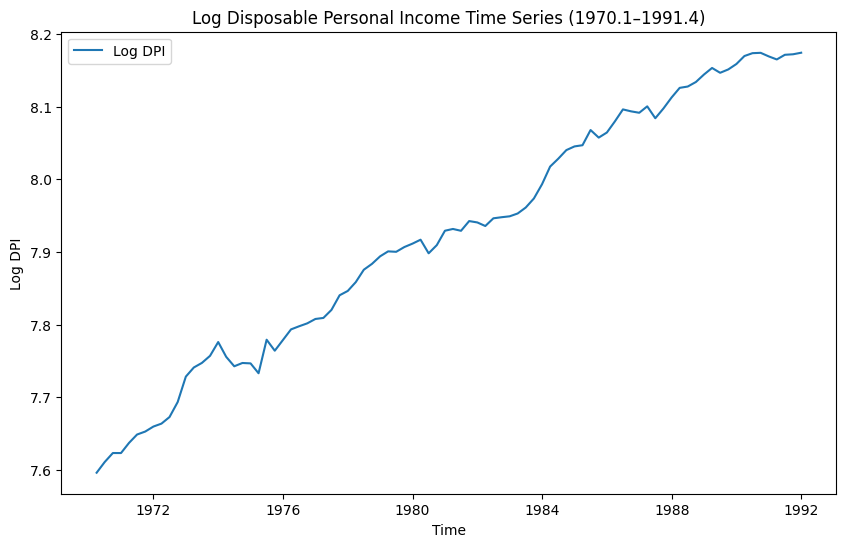

ADF Test on Original Series:
ADF Statistic: -1.4407471034265025
p-value: 0.5625931773883976
Critical Values: {'1%': np.float64(-3.512738056978279), '5%': np.float64(-2.8974898650628984), '10%': np.float64(-2.585948732897085)}
Series is non-stationary (fail to reject null hypothesis)

ADF Test on First Differenced Series:
ADF Statistic: -4.66915965544451
p-value: 9.612498486181354e-05
Critical Values: {'1%': np.float64(-3.512738056978279), '5%': np.float64(-2.8974898650628984), '10%': np.float64(-2.585948732897085)}
Series is stationary (reject null hypothesis)


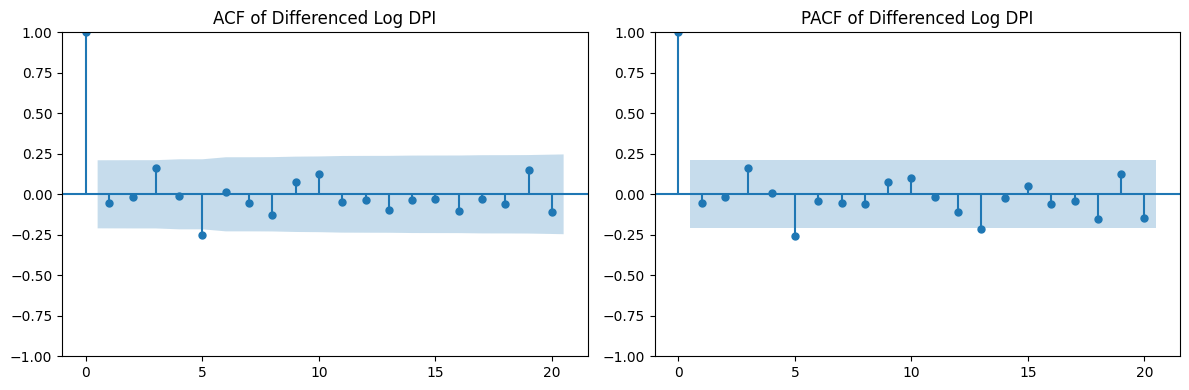

                               SARIMAX Results                                
Dep. Variable:                log_dpi   No. Observations:                   88
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 270.603
Date:                Fri, 13 Jun 2025   AIC                           -535.206
Time:                        17:39:21   BIC                           -527.808
Sample:                    03-31-1970   HQIC                          -532.227
                         - 12-31-1991                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.004    227.570      0.000       0.991       1.008
ma.L1         -0.9856      0.122     -8.047      0.000      -1.226      -0.746
sigma2         0.0001   1.75e-05      6.469      0.0

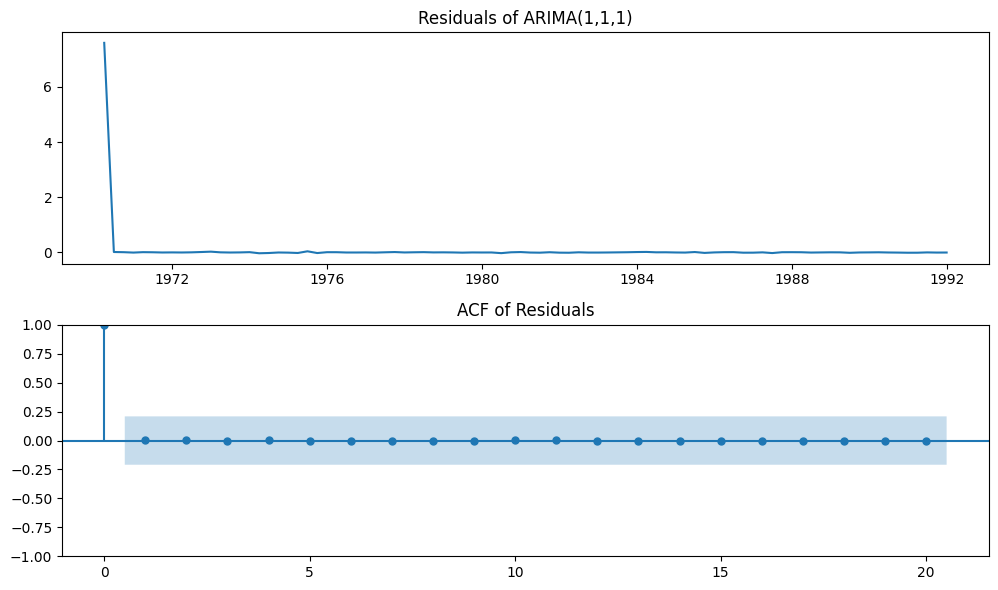

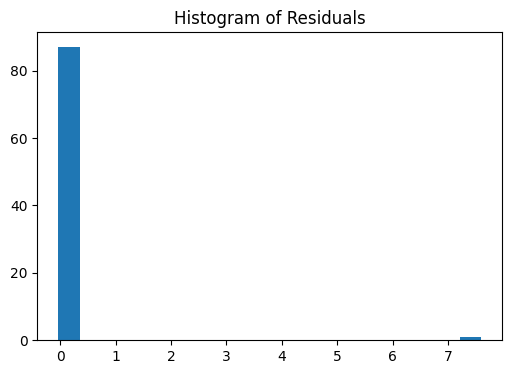

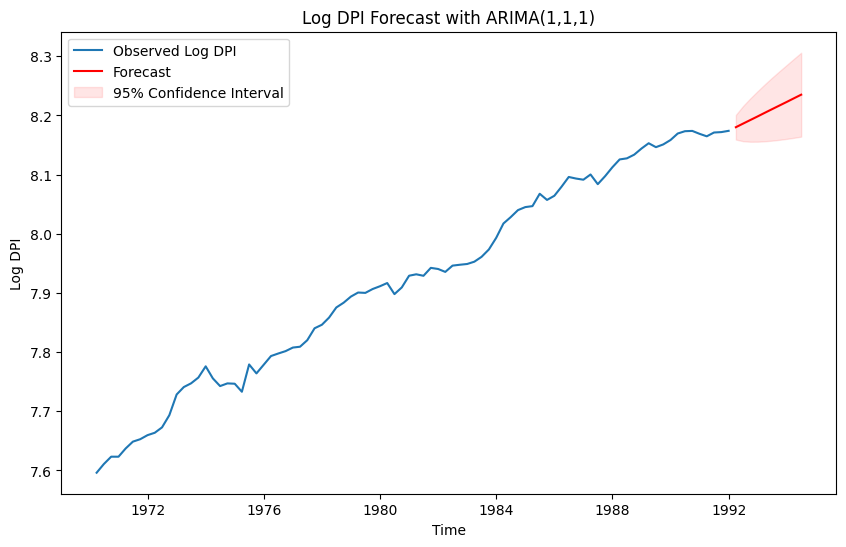

Note: The ARIMA(1,1,1) model is a starting point. Adjust (p,d,q) based on ACF/PACF plots and AIC/BIC values if needed.
If seasonality is observed, consider SARIMA with seasonal_order=(P,D,Q,4) for quarterly data.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

# Step 1: Upload and load the data
print("Please upload Tabla1.txt")
uploaded = files.upload()
filename = 'Tabla1.txt'

# Inspect the first few lines of the file to confirm structure
with open(filename, 'r') as file:
    print("First 10 lines of Tabla1.txt:")
    for i, line in enumerate(file):
        if i < 10:
            print(line.strip())
        else:
            break

# Load the data, skipping 8 header rows and using space delimiter
data = pd.read_csv(filename, skiprows=8, delim_whitespace=True, header=0)

# Print column names and first few rows to verify
print("\nColumn names:")
print(data.columns)
print("\nFirst 5 rows of loaded data:")
print(data.head())

# Create log_dpi from PDI column (PDI is in levels, not logs)
if 'PDI' not in data.columns:
    print("Error: PDI column not found. Available columns:", data.columns)
    print("Please specify the correct column for Personal Disposable Income.")
    raise ValueError("PDI column missing")
data['log_dpi'] = np.log(data['PDI'].astype(float))

# Select log_dpi column and ensure numeric
data = data[['log_dpi']].copy()
data['log_dpi'] = pd.to_numeric(data['log_dpi'], errors='coerce')
print("\nData after creating log_dpi (first 5 rows):")
print(data.head())

# Check for NaN values
nan_count = data['log_dpi'].isna().sum()
print(f"\nNumber of NaN values in log_dpi: {nan_count}")
print(f"Number of non-NaN values in log_dpi: {len(data) - nan_count}")

# Remove NaN values
data = data.dropna()
print("\nData after dropna (first 5 rows):")
print(data.head())
print(f"Number of rows after dropna: {len(data)}")

# Stop if no valid data remains
if len(data) == 0:
    print("Error: No valid numeric data in log_dpi column. Please check Tabla1.txt content.")
    print("Possible issues:")
    print("- PDI values are not numeric or contain formatting errors.")
    print("- Incorrect skiprows or delimiter.")
    print("Suggestions:")
    print("- Verify PDI column contains numeric values (e.g., 1990.6).")
    print("- Check for commas as decimal separators or other formatting.")
    raise ValueError("Empty data after preprocessing")

# Set quarterly date index (1970.1 to 1991.4, ~88 quarters)
data.index = pd.date_range(start='1970-01-01', periods=len(data), freq='Q')

# Step 2: Exploratory Data Analysis
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data['log_dpi'], label='Log DPI')
plt.title('Log Disposable Personal Income Time Series (1970.1–1991.4)')
plt.xlabel('Time')
plt.ylabel('Log DPI')
plt.legend()
plt.show()

# Check stationarity with ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Series is stationary (reject null hypothesis)")
    else:
        print("Series is non-stationary (fail to reject null hypothesis)")

print("ADF Test on Original Series:")
adf_test(data['log_dpi'])

# If non-stationary, try first differencing
data['log_dpi_diff'] = data['log_dpi'].diff().dropna()
print("\nADF Test on First Differenced Series:")
adf_test(data['log_dpi_diff'].dropna())

# Plot ACF and PACF
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_acf(data['log_dpi_diff'].dropna(), lags=20, ax=plt.gca())
plt.title('ACF of Differenced Log DPI')
plt.subplot(122)
plot_pacf(data['log_dpi_diff'].dropna(), lags=20, ax=plt.gca())
plt.title('PACF of Differenced Log DPI')
plt.tight_layout()
plt.show()

# Step 3: Fit ARIMA Model
# Start with ARIMA(1,1,1) (adjust based on ACF/PACF)
model = ARIMA(data['log_dpi'], order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Step 4: Diagnostics
# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals of ARIMA(1,1,1)')
plt.subplot(212)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

# Check if residuals are normally distributed
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.show()

# Step 5: Forecasting
forecast_steps = 10
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
forecast_index = pd.date_range(start=data.index[-1] + pd.offsets.QuarterBegin(), periods=forecast_steps, freq='Q')
conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence intervals

# Plot original series and forecast
plt.figure(figsize=(10, 6))
plt.plot(data['log_dpi'], label='Observed Log DPI')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],  # Lower bound
                 conf_int.iloc[:, 1],  # Upper bound
                 color='red', alpha=0.1, label='95% Confidence Interval')
plt.title('Log DPI Forecast with ARIMA(1,1,1)')
plt.xlabel('Time')
plt.ylabel('Log DPI')
plt.legend()
plt.show()

# Step 6: Model Selection Note
print("Note: The ARIMA(1,1,1) model is a starting point. Adjust (p,d,q) based on ACF/PACF plots and AIC/BIC values if needed.")
print("If seasonality is observed, consider SARIMA with seasonal_order=(P,D,Q,4) for quarterly data.")